### Imports

In [ ]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import joblib

### Processing parameters

In [2]:
thres_mean_FD = 0.15 # mm
scrub_threshold = 0.15 # mm
thres_perc_scrub = 30 # % scubbed out

### Load all behavioral data

In [3]:
# load bochum data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()

### Load standardized scrubbed timeseries

In [4]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
#region names
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

### Calculate connectivity

In [5]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag

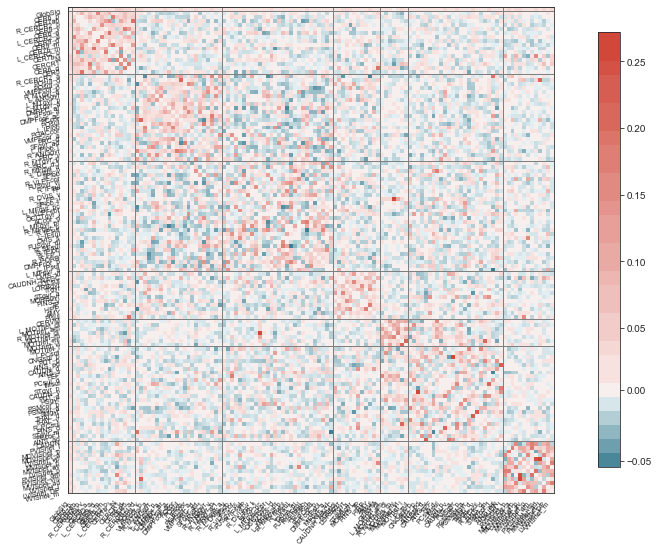

In [6]:
plot.plot_matrix(mat, labels, modules)

In [7]:
y = df.mean_QST_pain_sensitivity

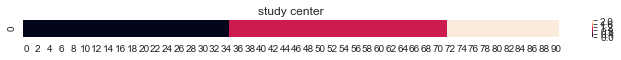

35 37 19


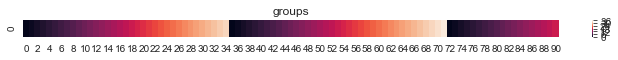

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

In [8]:
# create groups to balance-out cross-validations
plt.figure(figsize=(12, 0.3))
sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
sns.heatmap([groups]).set_title('groups')
plt.show()

groups

## Leave-one-study-out: nested

model	inner_cv mean score	outer vc score
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Fitting 30 folds for each of 18 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 14.0min finished


{'fsel__k': 25, 'model__alpha': 0.1, 'model__l1_ratio': 0.999} -0.6195488354362513 -0.5103470657106761
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71]
Fitting 30 folds for each of 18 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 12.1min finished


{'fsel__k': 25, 'model__alpha': 0.1, 'model__l1_ratio': 0.999} -0.3675877480125546 -0.9120180551872404
[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
Fitting 30 folds for each of 18 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 11.5min finished


{'fsel__k': 25, 'model__alpha': 0.01, 'model__l1_ratio': 0.999} -0.6380213837229871 -0.3582398008431123
*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.5417193223905977
** Mean Nested Crossvalidation Score (outer_cv):	-0.5935349739136763
Explained Variance: -0.0494762559435733
Correlation: 0.08918985630334599


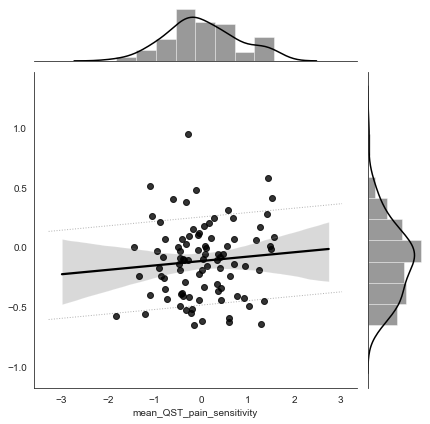

In [9]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          #p_grid = {'fsel__k': [10, 50, 100, 200, 500, 700, 1000, 2000, 3000, 4000, 5000, 'all'], 'model__alpha': [.001, .01, .1, 1, 10], 'model__l1_ratio': [0.001, .1, .3, .5, .7, .9, .999] 
                          p_grid = {'fsel__k': [25, 100, 500, 1000, 2000, 5000], 'model__alpha': [.001, .01, .1], 'model__l1_ratio': [.999]
                        }):
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

outer_cv = LeavePGroupsOut(1) #Leave-one-sudy-out
inner_cv = GroupKFold(30)   # do 30-fold quasi-balanced splits within the other two studies for hyperparam optimization.                                 
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=df.study):
    print(test)
    group_train = groups[train]                                
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1
                                    
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True)

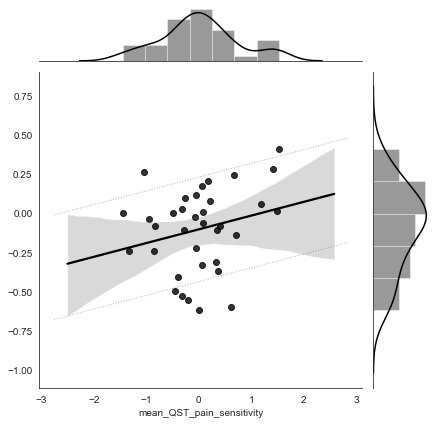

*** Score on mean as model:	-0.5197784675483742
** Mean score in the inner crossvaludation (inner_cv):	-0.6195488354362513
** Mean Nested Crossvalidation Score (outer_cv):	-0.5103470657106761
Explained Variance: 0.018145041448490384
Correlation: 0.24012825442516322


In [10]:
study='bochum'
plot.plot_prediction(y[df.study==study], predicted[df.study==study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study])))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train[0].mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test[0].mean()))
print("Explained Variance: " +  str( 1- nested_scores_test[0].mean()/-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study==study], predicted[df.study==study])[0,1]))

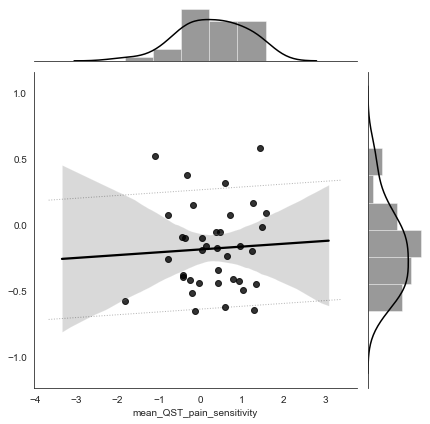

*** Score on mean as model:	-0.618370561472801
** Mean score in the inner crossvaludation (inner_cv):	-0.3675877480125546
** Mean Nested Crossvalidation Score (outer_cv):	-0.9120180551872404
Explained Variance: -0.47487301629470524
Correlation: 0.05373893815512351


In [11]:
study='essen'
plot.plot_prediction(y[df.study==study], predicted[df.study==study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study])))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train[1].mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test[1].mean()))
print("Explained Variance: " +  str( 1- nested_scores_test[1].mean()/-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study==study], predicted[df.study==study])[0,1]))

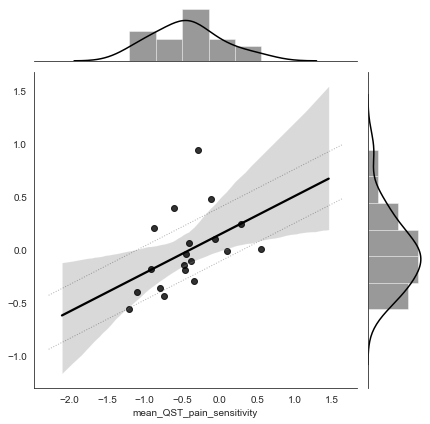

*** Score on mean as model:	-0.19811769701105597
** Mean score in the inner crossvaludation (inner_cv):	-0.6380213837229871
** Mean Nested Crossvalidation Score (outer_cv):	-0.3582398008431123
Explained Variance: -0.8082170661569961
Correlation: 0.4570080785931623


In [12]:
study='szeged'
plot.plot_prediction(y[df.study==study], predicted[df.study==study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study])))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train[2].mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test[2].mean()))
print("Explained Variance: " +  str( 1- nested_scores_test[2].mean()/-mean_squared_error(np.repeat(y[df.study==study].mean(), len(y[df.study==study])), y[df.study==study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study==study], predicted[df.study==study])[0,1]))

### save finalized models and nested cv predictions

In [26]:
# save nested cv-predictions
np.savetxt("nested_cv_pred_L1SO.csv", predicted, delimiter=",")

In [13]:
# essen+szeged -> bochum
joblib.dump(all_models[0], 'model_trained_on_essen+szeged.joblib')

# bochum+szeged -> essen
joblib.dump(all_models[1], 'model_trained_on_bochum+szeged.joblib')

# bochum+essen -> szeged
joblib.dump(all_models[2], 'model_trained_on_bochum+essen.joblib')


['model_trained_on_bochum+essen.joblib']

## Leave-two-study-out

model	inner_cv mean score	outer vc score
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Fitting 19 folds for each of 1 candidates, totalling 19 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   23.5s finished


{'fsel__k': 25, 'model__alpha': 0.005, 'model__l1_ratio': 0.999} -0.18328074513377432 -0.9104932283928476
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 72 73 74 75 76 77 78 79 80 81 82 83 84
 85 86 87 88 89 90]
Fitting 37 folds for each of 1 candidates, totalling 37 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   31.4s finished


{'fsel__k': 25, 'model__alpha': 0.005, 'model__l1_ratio': 0.999} -0.9693512556906422 -0.6122110662721487
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 83 84 85 86 87 88 89 90]
Fitting 35 folds for each of 1 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   31.0s finished


{'fsel__k': 25, 'model__alpha': 0.005, 'model__l1_ratio': 0.999} -0.31629062842366984 -0.4994664583750475
*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.4896408764160287
** Mean Nested Crossvalidation Score (outer_cv):	-0.6740569176800147
Explained Variance: -0.191853490275659
Correlation: 0.10331851877631136


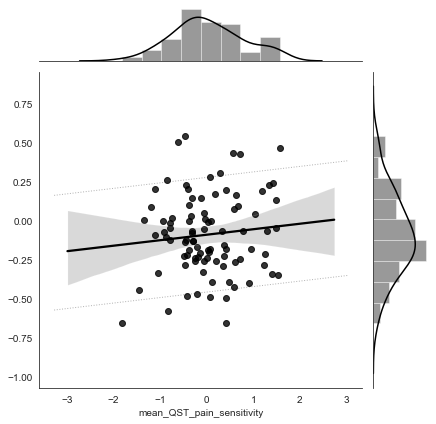

In [35]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                        #p_grid = {'fsel__k': [20, 25, 30, 35, 40, 45, 50, 60, 70, 80], 'model__alpha': [.001, .005, .01, .05, .1, .5], 'model__l1_ratio': [.999] } 
                        p_grid = {'fsel__k': [25], 'model__alpha': [.005], 'model__l1_ratio': [.999] }
                          ):
    mymodel = Pipeline(
        [('scaler', scaler), ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

outer_cv = LeavePGroupsOut(2) #Leave-two-sudy-out
inner_cv = LeaveOneOut()   # do LeaveOneOut within the study studies for hyperparam optimization.                                 
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=df.study):
    print(test)
    group_train = groups[train]                                
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] += clf.predict(X[test]) # we sum it to later construct an average
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1
    
predicted /= 2 # we take the mean prediction from the two predictions we summarised so far in leave-two-out
                                    
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True)

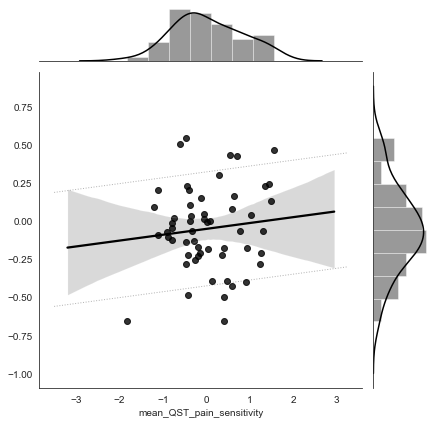

*** Score on mean as model:	-0.5936956355146823
Explained Variance: -0.5336026979607649
Correlation: 0.1092811465102116


In [36]:
# bochum -> essen + szeged
study='bochum'
plot.plot_prediction(y[df.study!=study], predicted[df.study!=study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study])))
print("Explained Variance: " +  str( 1- nested_scores_test[0].mean()/-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study!=study], predicted[df.study!=study])[0,1]))

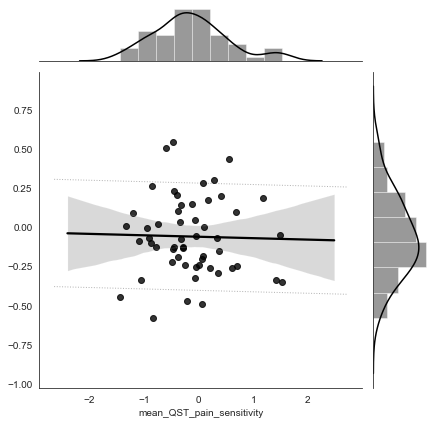

*** Score on mean as model:	-0.4516251050682339
Explained Variance: -1.016037678541554
Correlation: -0.024931038339356868


In [37]:
# essen -> bochum + szeged
study='essen'
plot.plot_prediction(y[df.study!=study], predicted[df.study!=study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study])))
print("Explained Variance: " +  str( 1- nested_scores_test[0].mean()/-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study!=study], predicted[df.study!=study])[0,1]))

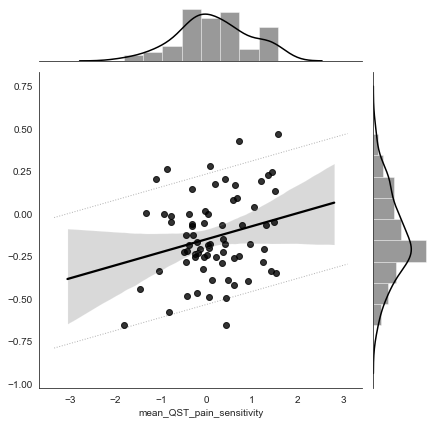

*** Score on mean as model:	-0.5901579200028748
Explained Variance: -0.5427959153516273
Correlation: 0.24335410602246302


In [38]:
# szeged -> essen + bochum
study='szeged'
plot.plot_prediction(y[df.study!=study], predicted[df.study!=study], sd=True)
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study])))
print("Explained Variance: " +  str( 1- nested_scores_test[0].mean()/-mean_squared_error(np.repeat(y[df.study!=study].mean(), len(y[df.study!=study])), y[df.study!=study]) ))
print("Correlation: " + str(np.corrcoef(y[df.study!=study], predicted[df.study!=study])[0,1]))

## save nested cv prediction

In [39]:
# save nested cv-predictions
np.savetxt("nested_cv_pred_L2SO.csv", predicted, delimiter=",")

## save models

In [21]:
# szeged -> bochum + essen
joblib.dump(all_models[0], 'model_trained_on_szeged.joblib')

# essen -> bochum + szeged
joblib.dump(all_models[1], 'model_trained_on_essen.joblib')

# bochum -> essen + szeged
joblib.dump(all_models[2], 'model_trained_on_bochum.joblib') # RPN-signature


['model_trained_on_bochum.joblib']

# full model with balanced nested cv

In [40]:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid = {'fsel__k': [2000], 'model__alpha': [.01], 'model__l1_ratio': [.999] 
                          #p_grid = {'fsel__k': [1000, 2000, 5000], 'model__alpha': [.001, .005, .01, .05, .1], 'model__l1_ratio': [.999]
                        }):
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]                                
    clf.fit(X[train], y[train], groups=group_train)
                                    
    print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1
                                    
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [34]:
# save nested cv-predictions
np.savetxt("nested_cv_pred_full_GroupKFold30.csv", predicted, delimiter=",")

Fitting 30 folds for each of 1 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.0s finished


**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 2000, 'model__alpha': 0.01, 'model__l1_ratio': 0.999}
** Score on full data as training set:	-0.0034061816882288527
** Score on mean as model: -0.5655535039999882
** Best Non-nested cross-validated score on test:	-0.2819469500871076
XXXXX Explained Variance: 0.5014672385672047


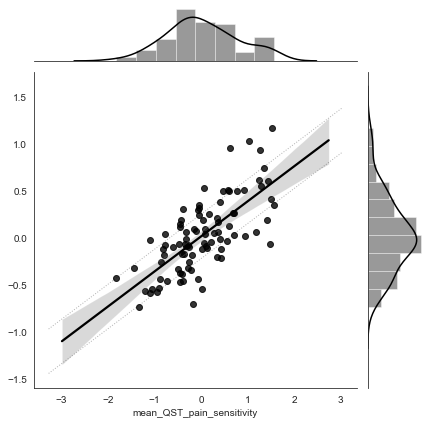

In [42]:
# finalize and save model
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          #p_grid = {'fsel__k': [50, 100, 500, 700, 1000, 2000, 5000, 'all'], 'model__alpha': [.001, .005, .01, .05, .1, .5], 'model__l1_ratio': [0.001, .1, .5, .7, .9, .999]
                          p_grid = {'fsel__k': [2000], 'model__alpha': [.01], 'model__l1_ratio': [.999]
         
                                   }):
                 
                        
    mymodel = Pipeline(
        [('scaler', scaler),
         ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

model, p_grid = pipe_scale_fsel_elnet()

cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X, y, groups=groups)
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))

joblib.dump(clf.best_estimator_, 'model_trained_on_all.joblib')

cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 
plot.plot_prediction(y, cv_pred, sd=True, covar=[])

#for train_index, test_index in group_kfold.split(X, y, groups):
#    #print("TRAIN:", train_index, "TEST:", test_index)
#    #print(df.study[train_index].values)
#    print('test:', df.study[test_index].values)

